In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
from cv2 import resize
from glob import glob

In [2]:
img_height = 224
img_width = 224


train_ds = tf.keras.utils.image_dataset_from_directory(
  'dataset',
  validation_split=0.2,
  subset='training',
  image_size=(img_height, img_width),
  batch_size=32,
  seed=42,
  shuffle=True)

val_ds = tf.keras.utils.image_dataset_from_directory(
  'dataset',
  validation_split=0.2,
  subset='validation',
  image_size=(img_height, img_width),
  batch_size=32,
  seed=42,
  shuffle=True)


Found 164 files belonging to 3 classes.
Using 132 files for training.
Found 164 files belonging to 3 classes.
Using 32 files for validation.


In [3]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)
base_model.trainable = False # Freeze VGG-16 for now

In [4]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = tf.keras.applications.vgg16.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(90)(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0     

In [5]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [6]:
num_epochs = 10
model.fit(train_ds, validation_data=val_ds, epochs=num_epochs,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=1e-2,
            patience=2,
            verbose=1,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
5/5 [==============================] - 10s 2s/step - loss: 10.6947 - accuracy: 0.0227 - val_loss: 5.7533 - val_accuracy: 0.0625
Epoch 2/10
5/5 [==============================] - 9s 2s/step - loss: 6.2685 - accuracy: 0.0985 - val_loss: 3.4858 - val_accuracy: 0.1875
Epoch 3/10
5/5 [==============================] - 9s 2s/step - loss: 4.4230 - accuracy: 0.2197 - val_loss: 2.2494 - val_accuracy: 0.4062
Epoch 4/10
5/5 [==============================] - 9s 2s/step - loss: 2.7349 - accuracy: 0.3939 - val_loss: 1.4945 - val_accuracy: 0.5938
Epoch 5/10
5/5 [==============================] - 9s 2s/step - loss: 2.4305 - accuracy: 0.4697 - val_loss: 0.9764 - val_accuracy: 0.6562
Epoch 6/10
5/5 [==============================] - 9s 2s/step - loss: 1.7707 - accuracy: 0.6136 - val_loss: 0.6683 - val_accuracy: 0.7188
Epoch 7/10
5/5 [==============================] - 9s 2s/step - loss: 1.1884 - accuracy: 0.6818 - val_loss: 0.4925 - val_accuracy: 0.8750
Epoch 8/10
5/5 [=======================

In [7]:
# fine tuning
base_model.trainable = True
for layer in base_model.layers[:14]:
    layer.trainable = False
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0     

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
num_epochs = 5
history = model.fit(train_ds, validation_data=val_ds, epochs=num_epochs,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=1e-2,
            patience=2,
            verbose=1,
        )
    ]
)

Epoch 1/5
5/5 [==============================] - 11s 2s/step - loss: 1.4091 - accuracy: 0.8182 - val_loss: 0.3754 - val_accuracy: 0.9062
Epoch 2/5
5/5 [==============================] - 11s 2s/step - loss: 0.1515 - accuracy: 0.9621 - val_loss: 0.0728 - val_accuracy: 0.9688
Epoch 3/5
5/5 [==============================] - 11s 2s/step - loss: 0.0186 - accuracy: 1.0000 - val_loss: 0.0181 - val_accuracy: 1.0000
Epoch 4/5
5/5 [==============================] - 11s 2s/step - loss: 0.0130 - accuracy: 0.9924 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 5/5
5/5 [==============================] - 11s 2s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000


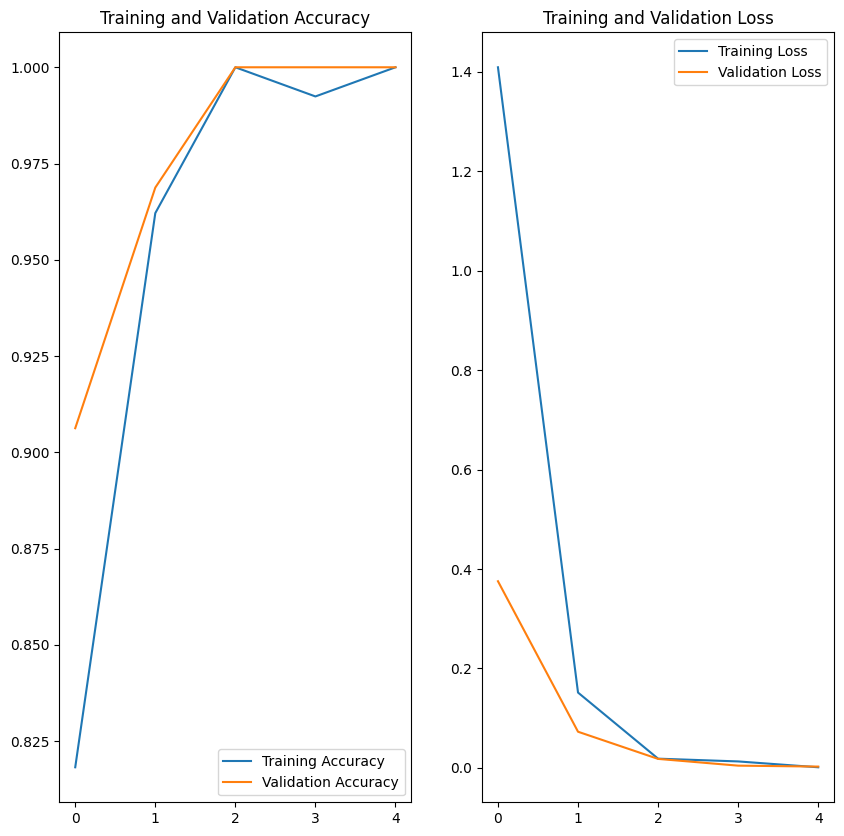

In [10]:
# Model Evaluation by comparing the training and validation accuracy as well as the loss.
acc = history.history['accuracy']
history.history
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
#
epochs_range = range(5)
#
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
#
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
model.save("chili.h5")

1/1 [==============================] - 0s 213ms/step
dataset/Stage_1/1.png most likely belongs to Stage_1 with a 100.00 percent confidence.


(-0.5, 223.5, 223.5, -0.5)

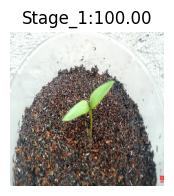

In [12]:
detection_path = "dataset/Stage_1/1.png"

img = tf.keras.utils.load_img(
    detection_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "{} most likely belongs to {} with a {:.2f} percent confidence."
    .format(detection_path, train_ds.class_names[np.argmax(score)], 100 * np.max(score))
)

plt.figure(figsize=(2, 2))
plt.imshow((img_array[0].numpy()).astype('uint8'))
plt.title("{}:{:.2f}".format(train_ds.class_names[np.argmax(score)], 100 * np.max(score)))
plt.axis('off')